In [1]:
import json
import os
import yaml

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP

import torch
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import rel_entr, kl_div


In [2]:
ROOT_DIR = '/mnt/home/floyed/code_for_brain_align'
DATA_DIR = f"{ROOT_DIR}/data"
FIGURES_DIR = f"{ROOT_DIR}/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

hcp2yeo7 = yaml.safe_load(open(f"{ROOT_DIR}/data/utils/Hcp2Yeo7.yaml"))

In [3]:
language_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/language_all.parquet')
vision_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/vision_all.parquet')
fmri_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/fmri_alignment.parquet')

In [4]:
language_df = language_df.dropna(axis=1, how='all')
vision_df = vision_df.dropna(axis=1, how='all')
language_df = language_df[(language_df['metric'] == 'cka_36')]
vision_df = vision_df[(vision_df['metric'] == 'cka_36')]
fmri_df = fmri_df[(fmri_df['metric'] == 'cka_36')]

In [5]:
def jensen_shannon_distance(p, q):
    epsilon = 1e-10

    p = np.maximum(p, epsilon)
    q = np.maximum(q, epsilon)

    p = p / np.sum(p)
    q = q / np.sum(q)

    m = 0.5 * (p + q)

    js_divergence = 0.5 * (np.sum(kl_div(p, m)) + np.sum(kl_div(q, m)))

    if np.isnan(js_divergence) or np.isinf(js_divergence):
        return 1.0

    return np.sqrt(max(0, js_divergence))


def compute_js_distance_matrix(cka_matrix):
    n_samples = cka_matrix.shape[0]
    dist_matrix = np.zeros((n_samples, n_samples))

    cka_matrix = np.nan_to_num(cka_matrix, nan=0.0, posinf=1.0, neginf=0.0)

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            dist = jensen_shannon_distance(cka_matrix[i, :], cka_matrix[j, :])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    return dist_matrix


def spread_vectors_preserve_magnitude(pca_matrix, spread_factor=1.5):

    magnitudes = np.sqrt(np.sum(pca_matrix ** 2, axis=1, keepdims=True))
    center = np.mean(pca_matrix, axis=0, keepdims=True)
    directions = pca_matrix - center
    norm_directions = directions / np.sqrt(np.sum(directions ** 2, axis=1, keepdims=True) + 1e-10)
    spread_matrix = center + norm_directions * magnitudes * spread_factor

    return spread_matrix


def extract_depth(feature_name):

    try:
        if '-' in feature_name:
            return int(feature_name.split('-')[-1])
        else:
            return 0
    except:
        return 0


def perform_dimensionality_reduction(df, method='ump', n_components=2, perplexity=30, sample_size=None, seed=42):
    feature_matrix = df.values

    feature_matrix = np.nan_to_num(feature_matrix, nan=0.0)

    indices = None
    if sample_size is not None and sample_size < feature_matrix.shape[0]:
        np.random.seed(seed)

        indices = list(range(sample_size))
        sampled_matrix = feature_matrix[indices]

        np.save('sampled_indices.npy', indices)
    else:
        sampled_matrix = feature_matrix

    scaler = StandardScaler()
    sampled_matrix = scaler.fit_transform(sampled_matrix)
    if method.lower() == 'pca':
        print(f"PCA -> {n_components}...")
        model = PCA(n_components=n_components)
        reduced_features = model.fit_transform(sampled_matrix)
        if hasattr(model, 'explained_variance_ratio_'):
            explained_var = model.explained_variance_ratio_
            print(f"PCA var: {explained_var}")
            print(f"PCA var sum: {sum(explained_var):.4f}")
    elif method.lower() == 'umap':

        # init
        sampled_matrix[180:] = sampled_matrix[180:] * 0.8 + (sampled_matrix[:180]).mean(axis=0) * 0.2
        pca = PCA(n_components=n_components, random_state=42)
        pca_matrix = pca.fit_transform(sampled_matrix)

        model = UMAP(
            n_components=n_components,
            n_neighbors=50,
            min_dist=1.,
            metric='cosine',
            init=pca_matrix,
            random_state=42,
            verbose=True
        )
        reduced_features = model.fit_transform(sampled_matrix)

    else:
        raise ValueError(f"Method not supported: {method}")

    return reduced_features, indices


def create_color_mapping(df, hcp2yeo7):

    unique_models = df['src_model'].unique()
    model_colors = {}

    base_colors = {'language': 'blue', 'vision': 'green', 'fmri': 'red'}

    unique_yeo7 = sorted(set(hcp2yeo7.values()))

    yeo7_to_color_idx = {
        'Visual': 0,
        'Somatomotor': 1,
        'Ventral Attention': 2,
        'Dorsal Attention': 3,
        'Limbic': 4,
        'Frontoparietal': 5,
    }

    yeo7_network_colors = {}
    colormaps = {
        'language': plt.cm.Reds,
        'vision': plt.cm.Blues
    }
    depth_ranges = {
        'language': {'min': float('inf'), 'max': float('-inf')},
        'vision': {'min': float('inf'), 'max': float('-inf')}
    }

    for model in unique_models:
        model_data = df[df['src_model'] == model]
        model_features = model_data['src_feature'].unique()
        if 'modality' in model_data.columns:
            modality = model_data['modality'].iloc[0]
        else:
            if 'fmri' in model.lower() or 'subj' in model.lower():
                modality = 'fmri'
            elif any(v in model.lower() for v in ['gpt', 'llama', 'bert']):
                modality = 'language'
            elif any(v in model.lower() for v in ['vit', 'clip', 'resnet']):
                modality = 'vision'
            else:
                modality = 'other'

        base_color = base_colors.get(modality, 'gray')

        if modality == 'fmri':
            colormap = plt.cm.get_cmap('hsv', len(unique_yeo7))

            for feature in model_features:
                feature_str = str(int(feature)) if isinstance(feature, (int, float)) else feature
                if feature_str in hcp2yeo7:
                    network = hcp2yeo7[feature_str]
                    if network == 'Default':
                        color = 'gray'
                    else:
                        color_idx = yeo7_to_color_idx[network]
                        normalized_idx = (color_idx / 5) * 0.6 + 0.2
                        color = colormap(normalized_idx)
                        model_colors[(model, feature)] = color
                    yeo7_network_colors[network] = color
                else:
                    model_colors[(model, feature)] = 'gray'
        else:
            if modality == 'language':
                colormap = plt.cm.Reds
            elif modality == 'vision':
                colormap = plt.cm.Blues
            else:
                colormap = plt.cm.Greys

            min_depth = min(model_features)
            max_depth = max(model_features)
            depth_range = max_depth - min_depth
            if depth_range == 0:
                depth_range = 1

            for feature in model_features:
                normalized_depth = 0.2 + 0.8 * (feature - min_depth) / depth_range
                color = colormap(normalized_depth)
                model_colors[(model, feature)] = color

                if modality in depth_ranges:
                    depth_ranges[modality]['min'] = min(depth_ranges[modality]['min'], feature)
                    depth_ranges[modality]['max'] = max(depth_ranges[modality]['max'], feature)

    return {
        'model_colors': model_colors,
        'yeo7_colors': yeo7_network_colors,
        'colormaps': colormaps,
        'depth_ranges': depth_ranges
    }


def plot_reduced_dimensions(df, reduced_features, color_mapping_data, save_path=None, annotate=False, legend=True):
    fig = plt.figure(figsize=(4, 3.2))

    left_margin, bottom_margin, right_margin, top_margin = 0.00, 0.00, 0.20, 0.00
    main_ax = fig.add_axes([left_margin, bottom_margin,
                            1.0 - left_margin - right_margin,
                            1.0 - bottom_margin - top_margin])

    model_colors = color_mapping_data['model_colors']
    yeo7_colors = color_mapping_data['yeo7_colors']
    colormaps = color_mapping_data['colormaps']
    depth_ranges = color_mapping_data['depth_ranges']

    df_reset = df.reset_index() if isinstance(df.index, pd.MultiIndex) else df

    markers = {'language': 'o', 'vision': 's', 'fmri': '*'}
    marker_sizes = {'language': 12, 'vision': 8, 'fmri': 32}

    modality_markers = {}
    texts = []

    modality_order = ['vision', 'language', 'fmri']

    for current_modality in modality_order:
        for i, (_, row) in enumerate(df_reset.iterrows()):
            model = row['src_model']
            feature = row['src_feature']

            if 'modality' in row:
                modality = row['modality']
            else:
                if 'fmri' in model.lower() or 'subj' in model.lower():
                    modality = 'fmri'
                elif any(v in model.lower() for v in ['gpt', 'llama', 'bert']):
                    modality = 'language'
                elif any(v in model.lower() for v in ['vit', 'clip', 'resnet']):
                    modality = 'vision'
                else:
                    modality = 'other'

            if modality != current_modality:
                continue

            color = model_colors.get((model, feature), 'gray')
            marker = markers.get(modality, 'o')
            size = marker_sizes.get(modality, 30)

            modality_markers[modality] = marker

            scatter = main_ax.scatter(
                reduced_features[i, 0],
                reduced_features[i, 1],
                color=color,
                marker=marker,
                s=size,
                # alpha=0.8
            )

            if annotate:
                label = f"{model}-{feature:.2f}"
                txt = main_ax.text(reduced_features[i, 0], reduced_features[i, 1], label, ha='center', va='center')
                texts.append(txt)

    if annotate and texts:
        from adjustText import adjust_text
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    from matplotlib.lines import Line2D

    modality_handles = []
    for modality in modality_order:
        if modality in modality_markers:
            marker = markers[modality]

            markersize = 9 if modality == 'fmri' else 6
            modality_handles.append(
                Line2D([0], [0], marker=marker, color='none', markeredgecolor='black',
                       markerfacecolor='none', markersize=markersize, label=modality.capitalize())
            )

    fmri_legend = []
    if yeo7_colors:
        for network, color in sorted(yeo7_colors.items()):
            fmri_legend.append(
                Line2D([0], [0], marker='*', color='none', markeredgecolor='black',
                       markerfacecolor=color, markersize=8,
                       label=f"{network}")
            )

    if legend:
        cbar_ax1 = fig.add_axes([0.825, 0.525, 0.02, 0.475])
        cbar_ax2 = fig.add_axes([0.825, 0.0, 0.02, 0.475])

        if 'language' in depth_ranges and depth_ranges['language']['min'] != float('inf'):
            norm = plt.Normalize(0, 1)
            sm = plt.cm.ScalarMappable(cmap=colormaps['language'], norm=norm)
            sm.set_array([])


            cbar = plt.colorbar(sm, cax=cbar_ax1)
            cbar.set_label('Language Feature Depth')  # , fontsize=9


        if 'vision' in depth_ranges and depth_ranges['vision']['min'] != float('inf'):
            norm = plt.Normalize(0, 1)
            sm = plt.cm.ScalarMappable(cmap=colormaps['vision'], norm=norm)
            sm.set_array([])


            cbar = plt.colorbar(sm, cax=cbar_ax2)
            cbar.set_label('Vision Feature Depth')  #, fontsize=9

        modality_leg = fig.legend(
            handles=modality_handles,
            loc='upper center',
            bbox_to_anchor=(0.525, 0.985),
            frameon=False,
            ncol=3,
            fontsize=7,
            columnspacing=1.0
        )

        if fmri_legend:
            fmri_leg = fig.legend(handles=fmri_legend,
                                  loc='upper left',
                                  bbox_to_anchor=(0.01, 0.9925),
                                  frameon=False,
                                  fontsize=7,
                                  title="Brain Regions")

    main_ax.set_xlabel('Component 1')  # , fontsize=10
    main_ax.set_ylabel('Component 2')  # , fontsize=10
    main_ax.grid(True, linestyle='--', alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        plt.savefig(save_path.replace('png', 'pdf'), bbox_inches='tight')
        print(f"Figure has been saved to: {save_path}")

    return fig, main_ax

In [6]:
def plot_reduced_dimensions_3d(df, reduced_features, color_mapping_data, save_path=None, annotate=False, legend=True):

    fig = plt.figure(figsize=(5, 3.6))

    left_margin, bottom_margin, right_margin, top_margin = 0.00, 0.00, 0.08, 0.00
    main_ax = fig.add_axes([left_margin, bottom_margin,
                            1.0 - left_margin - right_margin,
                            1.0 - bottom_margin - top_margin], projection='3d')

    model_colors = color_mapping_data['model_colors']
    yeo7_colors = color_mapping_data['yeo7_colors']
    colormaps = color_mapping_data['colormaps']
    depth_ranges = color_mapping_data['depth_ranges']

    df_reset = df.reset_index() if isinstance(df.index, pd.MultiIndex) else df

    markers = {'language': 'o', 'vision': 's', 'fmri': '*'}
    marker_sizes = {'language': 8, 'vision': 8, 'fmri': 56}

    modality_markers = {}
    texts = []

    modality_order = ['vision', 'language', 'fmri']

    for current_modality in modality_order:
        for i, (_, row) in enumerate(df_reset.iterrows()):
            model = row['src_model']
            feature = row['src_feature']

            if 'modality' in row:
                modality = row['modality']
            else:
                if 'fmri' in model.lower() or 'subj' in model.lower():
                    modality = 'fmri'
                elif any(v in model.lower() for v in ['gpt', 'llama', 'bert']):
                    modality = 'language'
                elif any(v in model.lower() for v in ['vit', 'clip', 'resnet']):
                    modality = 'vision'
                else:
                    modality = 'other'

            if modality != current_modality:
                continue

            color = model_colors.get((model, feature), 'gray')
            marker = markers.get(modality, 'o')
            size = marker_sizes.get(modality, 56)

            modality_markers[modality] = marker

            scatter = main_ax.scatter(
                reduced_features[i, 0],
                reduced_features[i, 1],
                reduced_features[i, 2],
                color=color,
                edgecolors='none' if modality != 'fmri' else 'black',
                linewidth=0.36 if modality == 'fmri' else 0,
                marker=marker,
                s=size,
                alpha=0.24 if modality != 'fmri' else 0.8,
            )

            if annotate:
                label = f"{model}-{feature:.2f}"
                txt = main_ax.text(
                    reduced_features[i, 0],
                    reduced_features[i, 1],
                    reduced_features[i, 2],
                    label, ha='center', va='center'
                )
                texts.append(txt)

    if annotate and texts:
        from adjustText import adjust_text
        try:
            adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
        except Exception as e:
            print(f"{e}")

    from matplotlib.lines import Line2D

    modality_handles = []
    for modality in modality_order:
        if modality in modality_markers:
            marker = markers[modality]

            markersize = 9 if modality == 'fmri' else 6
            modality_handles.append(
                Line2D([0], [0], marker=marker, color='none', markeredgecolor='black', linewidth=0.5,
                       markerfacecolor='none', markersize=markersize, label=modality.capitalize())
            )

    fmri_legend = []
    if yeo7_colors:
        for network, color in sorted(yeo7_colors.items()):
            fmri_legend.append(
                Line2D([0], [0], marker='*', color='none', markeredgecolor='black',
                       markerfacecolor=color, markersize=8,
                       label=f"{network}")
            )

    cbar_ax1 = fig.add_axes([0.825, 0.55, 0.02, 0.40])
    cbar_ax2 = fig.add_axes([0.825, 0.05, 0.02, 0.40])

    if 'language' in depth_ranges and depth_ranges['language']['min'] != float('inf'):
        norm = plt.Normalize(0, 1)
        sm = plt.cm.ScalarMappable(cmap=colormaps['language'], norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, cax=cbar_ax1)
        cbar.set_label('Language Feature Depth')

    if 'vision' in depth_ranges and depth_ranges['vision']['min'] != float('inf'):
        norm = plt.Normalize(0, 1)
        sm = plt.cm.ScalarMappable(cmap=colormaps['vision'], norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, cax=cbar_ax2)
        cbar.set_label('Vision Feature Depth')

    if legend:

        modality_leg = fig.legend(
            handles=modality_handles,
            loc='upper center',
            bbox_to_anchor=(0.7, 0.95),
            frameon=False,
            ncol=1,
            # fontsize=7,
            columnspacing=1.0
        )

        if fmri_legend:
            fmri_leg = fig.legend(
                handles=fmri_legend,
                loc='upper left',
                bbox_to_anchor=(0.12, 0.9525),
                frameon=False,
                # fontsize=7,
                title="Brain Regions"
            )

    main_ax.set_xlabel('Component #3', labelpad=-6)
    main_ax.set_ylabel('Component #2', labelpad=-6)
    main_ax.set_zlabel('Component #1', labelpad=-11)

    main_ax.grid(True, linestyle='--', alpha=0.3)

    main_ax.view_init(elev=15, azim=30)

    main_ax.tick_params(axis='x', pad=-3)
    main_ax.tick_params(axis='y', pad=-3)
    main_ax.tick_params(axis='z', pad=-4)

    x_min, x_max = main_ax.get_xlim()
    y_min, y_max = main_ax.get_ylim()
    z_min, z_max = main_ax.get_zlim()

    x_ticks = np.linspace(x_min, x_max, 7)[1:-1]
    y_ticks = np.linspace(y_min, y_max, 7)[1:-1]
    z_ticks = np.linspace(z_min, z_max, 7)[1:-1]

    main_ax.set_xticks(x_ticks)
    main_ax.set_yticks(y_ticks)
    main_ax.set_zticks(z_ticks)

    main_ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
    main_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
    main_ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))

    main_ax.xaxis.pane.set_edgecolor('gray')
    main_ax.yaxis.pane.set_edgecolor('gray')
    main_ax.zaxis.pane.set_edgecolor('gray')
    main_ax.xaxis.pane.fill = False
    main_ax.yaxis.pane.fill = False
    main_ax.zaxis.pane.fill = False

    # plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        plt.savefig(save_path.replace('png', 'pdf'), bbox_inches='tight')
        print(f"Figure has been saved to: {save_path}")

    return fig, main_ax

In [7]:
def main(df, method='pca', n_components=2, compute_new=False, sample_size=None,
         filename=None, save_path=None, hcp2yeo7=None, annotate=False, legend=True, seed=42):

    if filename is None:
        filename = f'{method}_features.npy'

    if save_path is None:
        save_path = f'{method}_dimensionality_reduction.png'

    color_mapping_data = create_color_mapping(df.reset_index() if isinstance(df.index, pd.MultiIndex) else df, hcp2yeo7)

    reduced_features, indices = perform_dimensionality_reduction(
        df, method=method, n_components=n_components, sample_size=sample_size, seed=seed
    )

    if indices is not None:
        if isinstance(df.index, pd.MultiIndex):
            sampled_df = df.reset_index().iloc[indices].set_index(df.index.names)
        else:
            sampled_df = df.iloc[indices]
        if n_components == 2:
            plt = plot_reduced_dimensions(sampled_df, reduced_features, color_mapping_data, save_path, annotate, legend)
        else:
            plt = plot_reduced_dimensions_3d(sampled_df, reduced_features, color_mapping_data, save_path, annotate, legend)

    else:
        if n_components == 2:
            plt = plot_reduced_dimensions(df, reduced_features, color_mapping_data, save_path, annotate, legend)
        else:
            plt = plot_reduced_dimensions_3d(df, reduced_features, color_mapping_data, save_path, annotate, legend)

    return reduced_features, plt

/tmp/ipykernel_425450/3547947453.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('hsv', len(unique_yeo7))
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, init=array([[ 49.11395085, -0.38497651],
       [ 49.76341036, -25.80158895],
       [ 43.55093645, -23.10659637],
       ...,
       [ -2.327447  , -0.06593356],
       [ -1.9867983 , -0.05910176],
       [  0.66031112, -0.05605629]]), metric='cosine', min_dist=1.0, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Apr 21 03:36:09 2025 Construct fuzzy simplicial set
Mon Apr 21 03:36:09 2025 Finding Nearest Neighbors
Mon Apr 21 03:36:09 2025 Building RP forest with 9 trees
Mon Apr 21 03:36:14 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Mon Apr 21 03:36:34 2025 Finished Nearest Neighbor Search
Mon Apr 21 03:36:38 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Apr 21 03:36:48 2025 Finished embedding
Figure has been saved to: /mnt/home/floyed/code_for_brain_align/figures/scatter/subj07-subj07/subj07.png


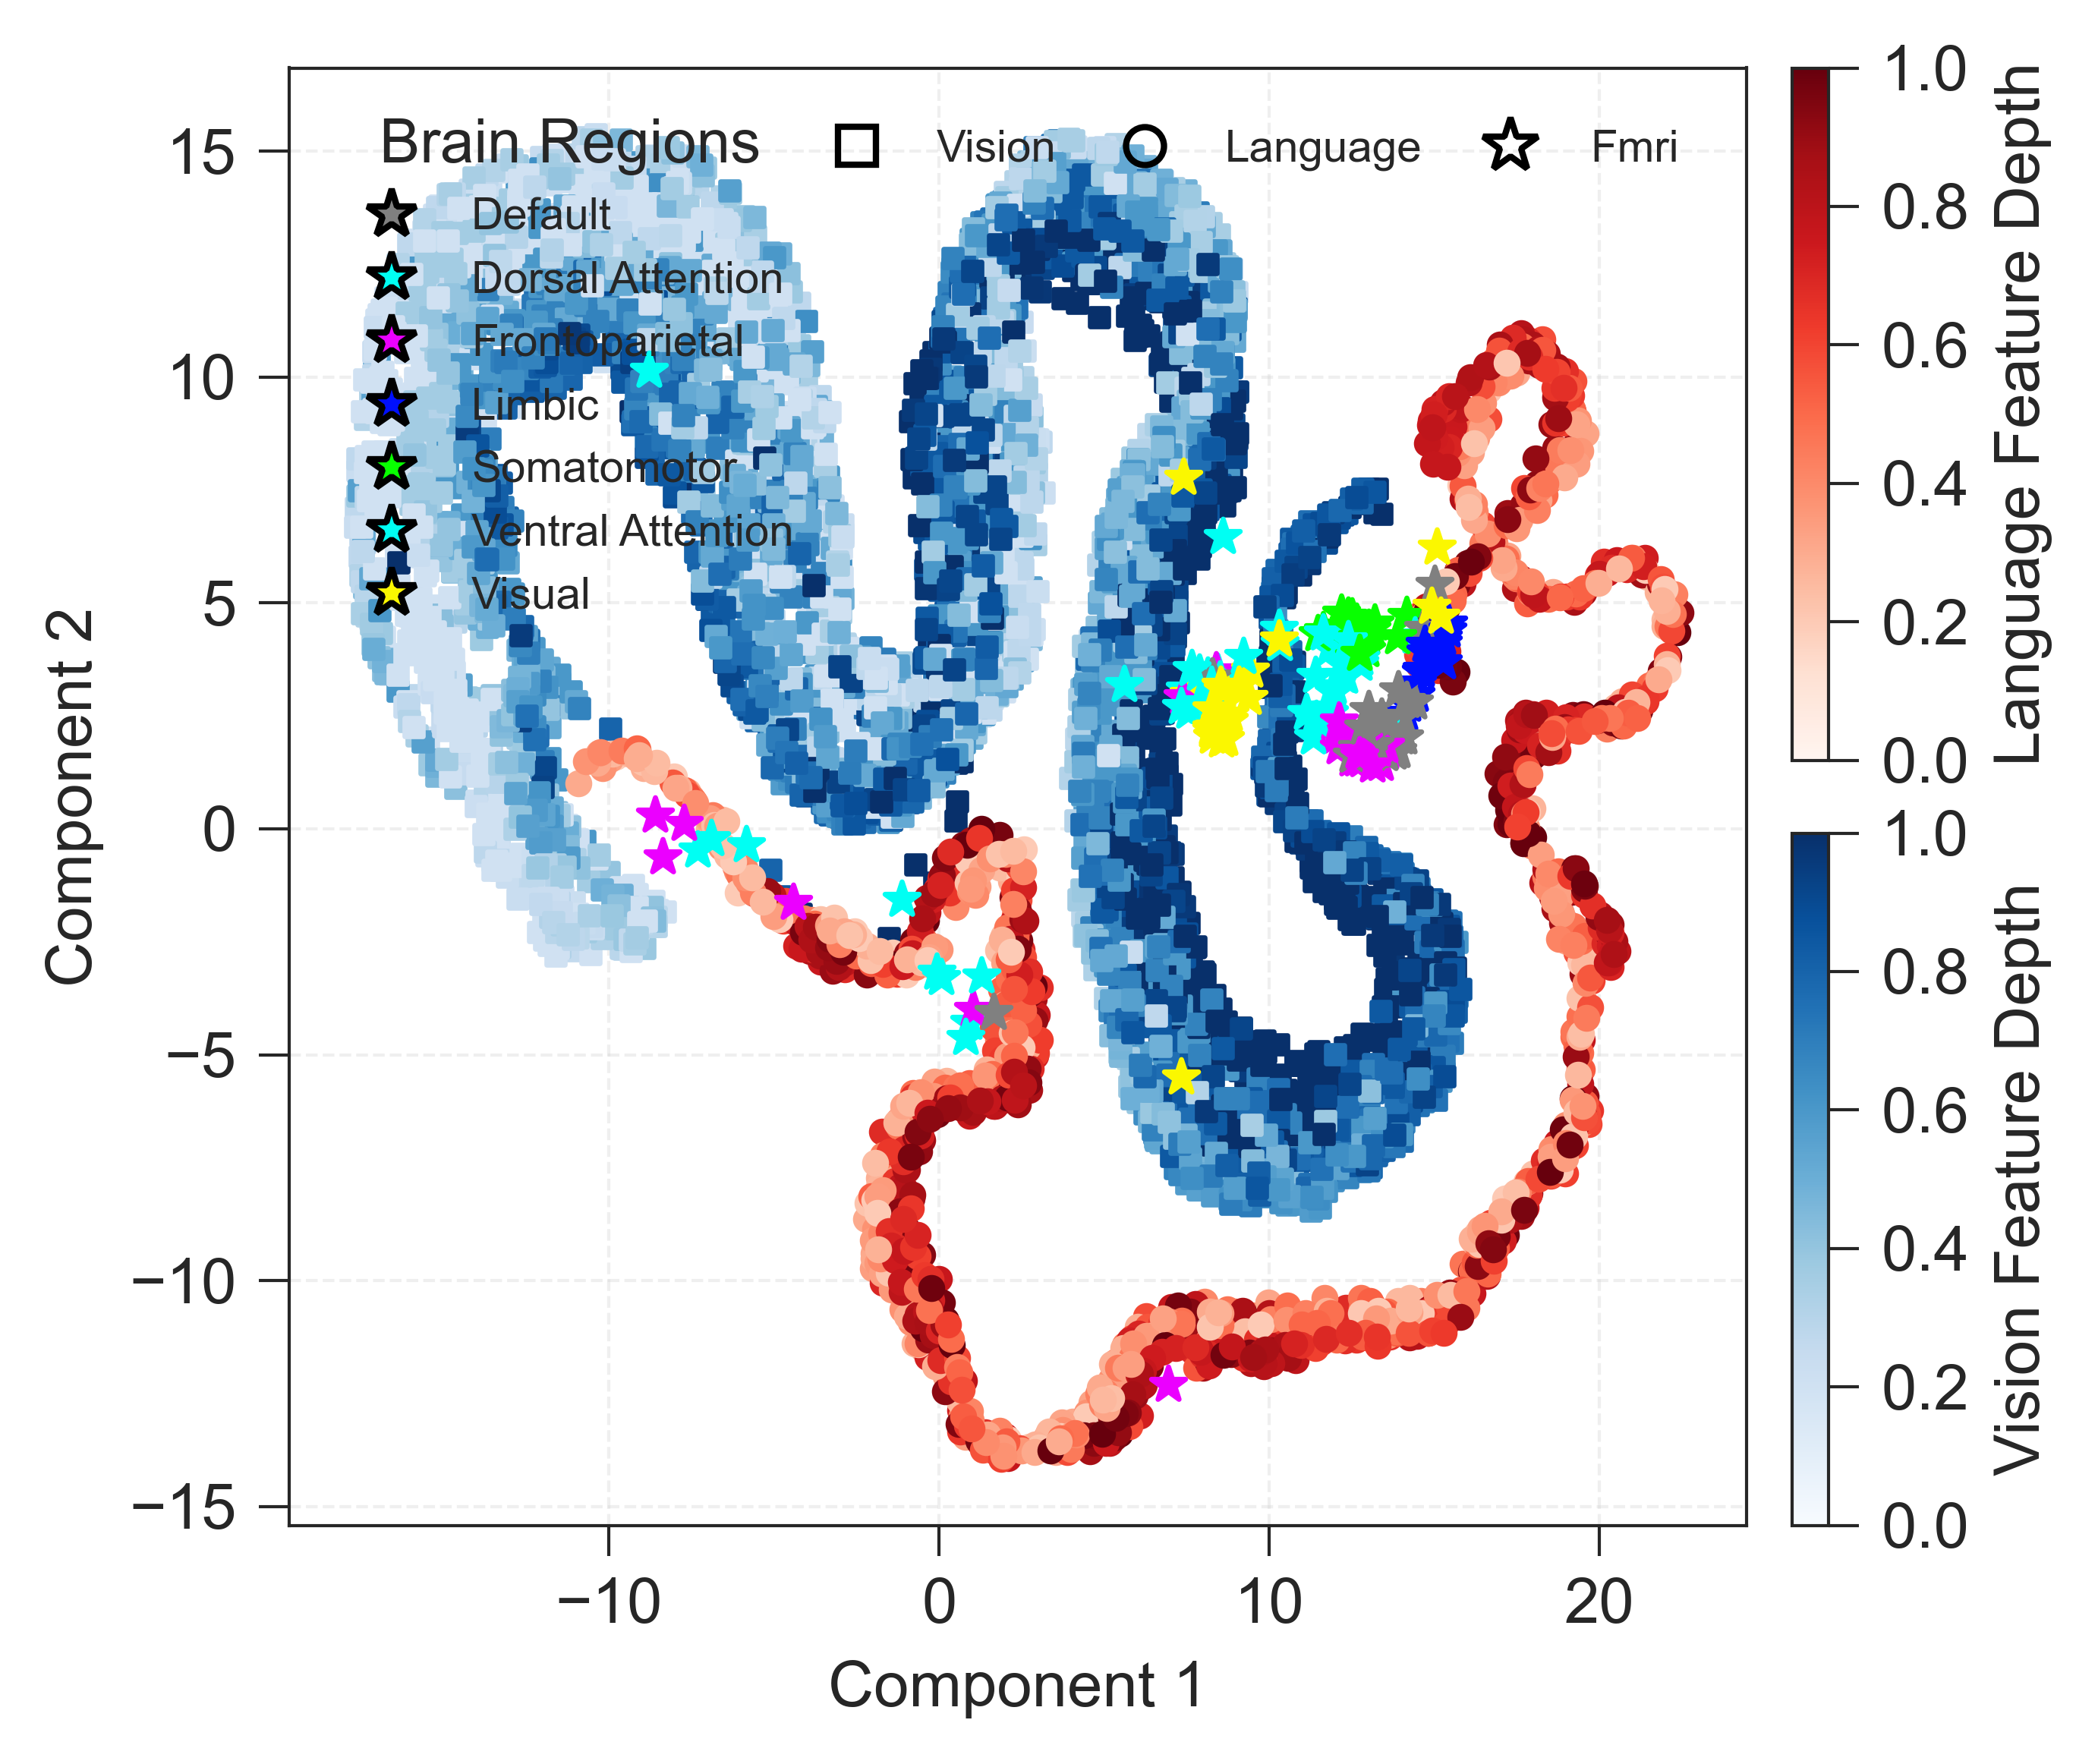

/tmp/ipykernel_425450/3547947453.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('hsv', len(unique_yeo7))
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, init=array([[ 37.0715063 , 50.82579878],
       [ 58.60283267, -35.16694054],
       [ 36.3038859 , -25.25108958],
       ...,
       [ -2.26915206, -0.29676519],
       [ -1.94293126, -0.22907043],
       [  0.82578984, 0.33997118]]), metric='cosine', min_dist=1.0, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Apr 21 03:38:17 2025 Construct fuzzy simplicial set
Mon Apr 21 03:38:17 2025 Finding Nearest Neighbors
Mon Apr 21 03:38:17 2025 Building RP forest with 9 trees
Mon Apr 21 03:38:17 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 21 03:38:18 2025 Finished Nearest Neighbor Search
Mon Apr 21 03:38:18 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Apr 21 03:38:28 2025 Finished embedding
Figure has been saved to: /mnt/home/floyed/code_for_brain_align/figures/scatter/subj05-subj05/subj05.png


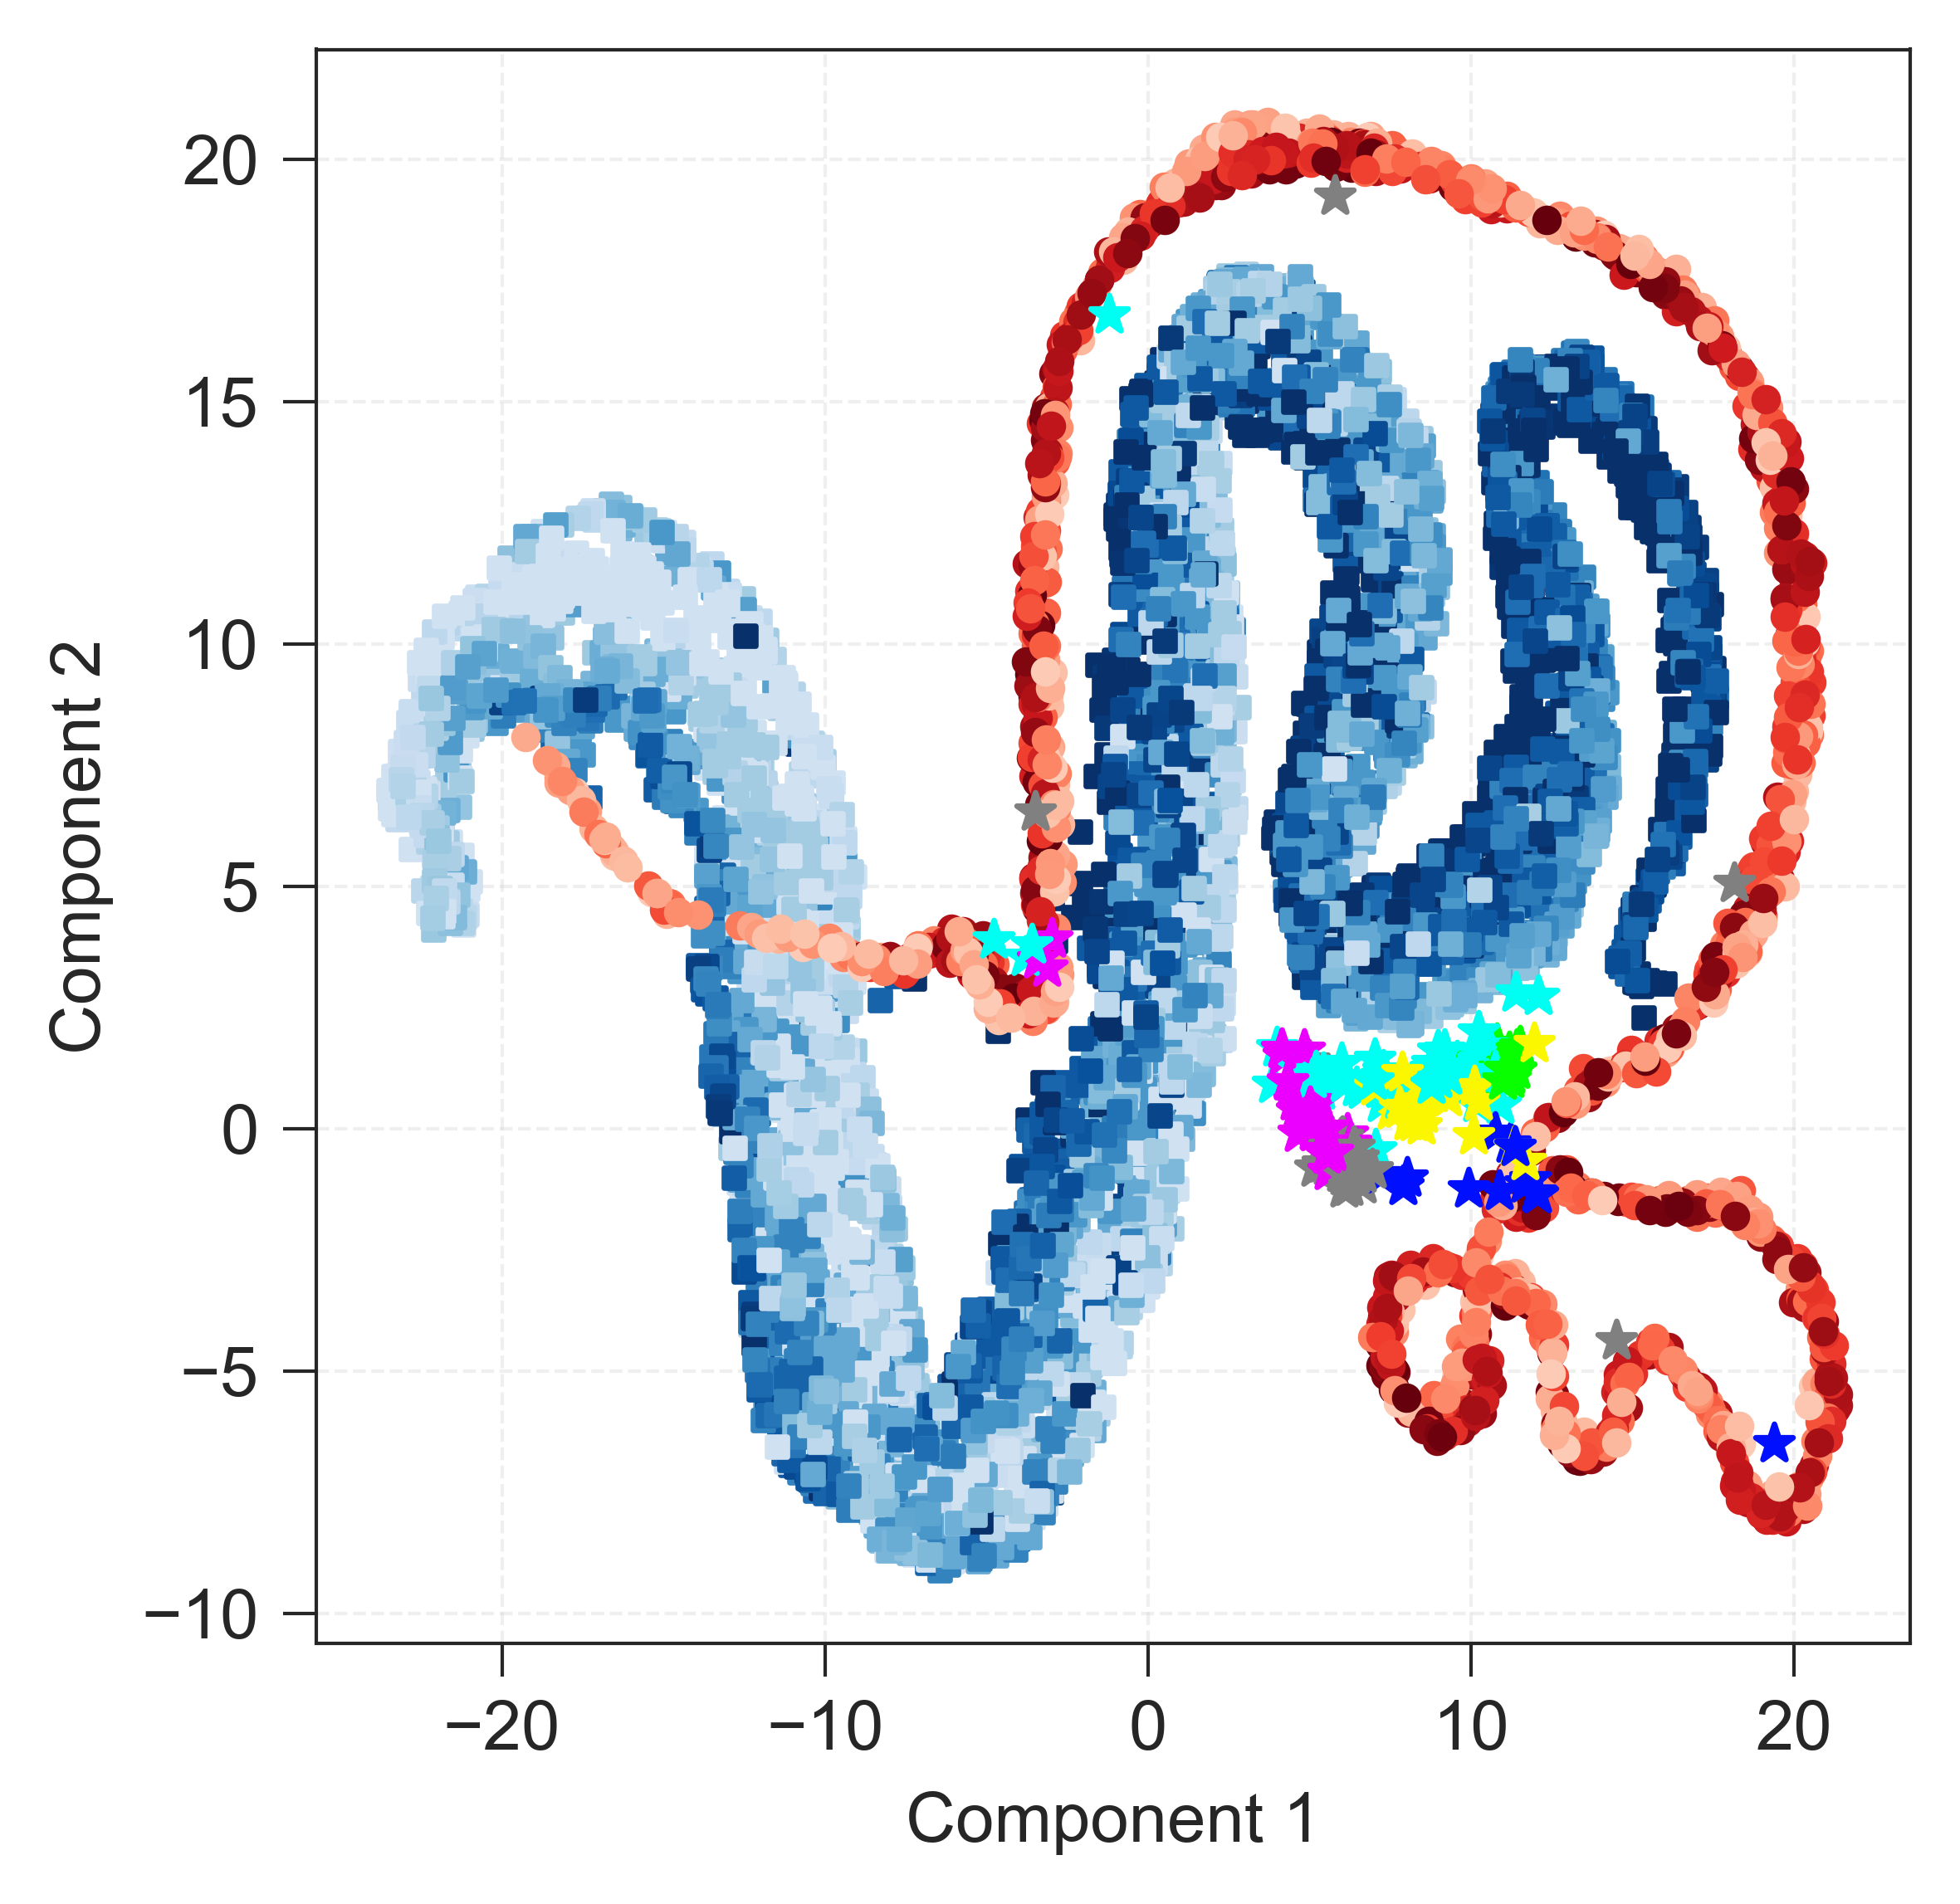

/tmp/ipykernel_425450/3547947453.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('hsv', len(unique_yeo7))
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, init=array([[ 41.3495259 , 49.85677359],
       [ 58.51887867, -27.4878473 ],
       [ 26.37232246, -9.69551638],
       ...,
       [ -2.39852169, -0.40616786],
       [ -2.0037928 , -0.28304986],
       [  0.92124765, 0.58762785]]), metric='cosine', min_dist=1.0, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Apr 21 03:39:57 2025 Construct fuzzy simplicial set
Mon Apr 21 03:39:57 2025 Finding Nearest Neighbors
Mon Apr 21 03:39:57 2025 Building RP forest with 9 trees
Mon Apr 21 03:39:57 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 21 03:39:59 2025 Finished Nearest Neighbor Search
Mon Apr 21 03:39:59 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Apr 21 03:40:08 2025 Finished embedding
Figure has been saved to: /mnt/home/floyed/code_for_brain_align/figures/scatter/subj02-subj02/subj02.png


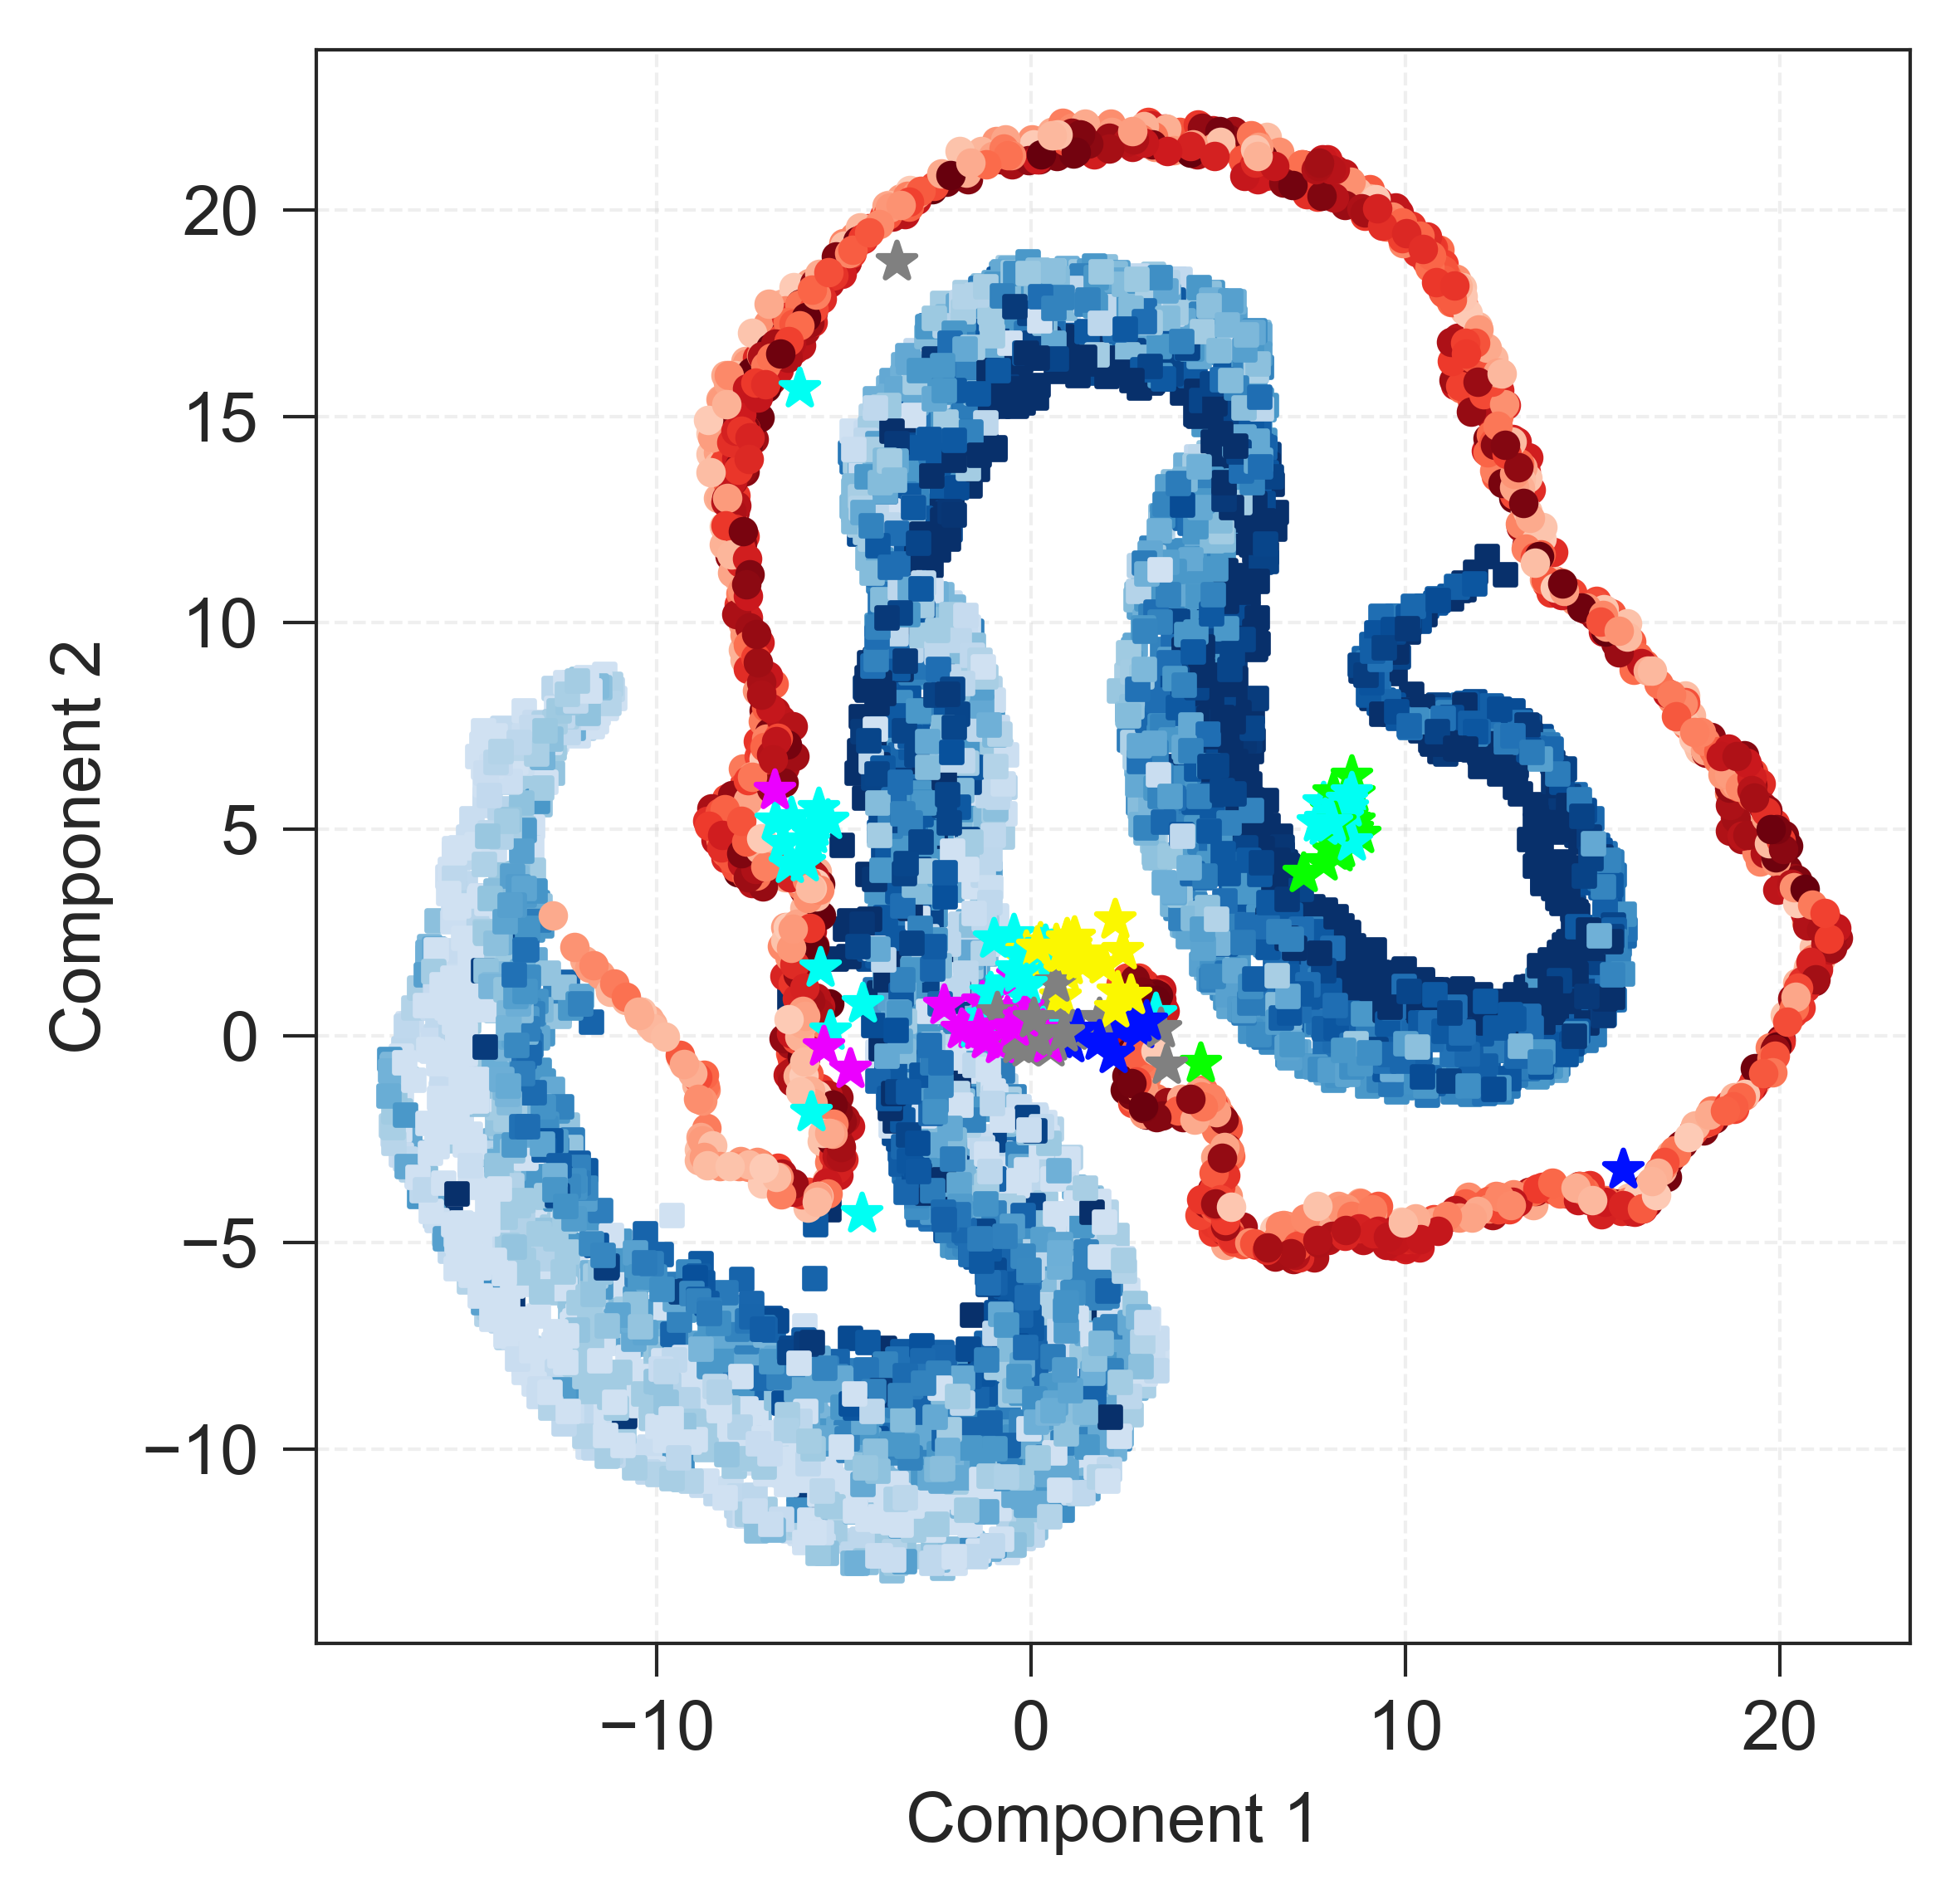

/tmp/ipykernel_425450/3547947453.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('hsv', len(unique_yeo7))
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, init=array([[ 5.63830838e+01, 2.69324045e+00],
       [ 5.79493376e+01, -2.85757372e+01],
       [ 4.45615671e+01, -2.08954956e+01],
       ...,
       [-2.27785420e+00, -1.57800304e-02],
       [-1.89744426e+00, 7.49266758e-02],
       [ 5.74384730e-01, 7.47006679e-03]]), metric='cosine', min_dist=1.0, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Apr 21 03:41:37 2025 Construct fuzzy simplicial set
Mon Apr 21 03:41:37 2025 Finding Nearest Neighbors
Mon Apr 21 03:41:37 2025 Building RP forest with 9 trees
Mon Apr 21 03:41:37 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 21 03:41:39 2025 Finished Nearest Neighbor Search
Mon Apr 21 03:41:39 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Apr 21 03:41:48 2025 Finished embedding
Figure has been saved to: /mnt/home/floyed/code_for_brain_align/figures/scatter/subj01-subj01/subj01.png


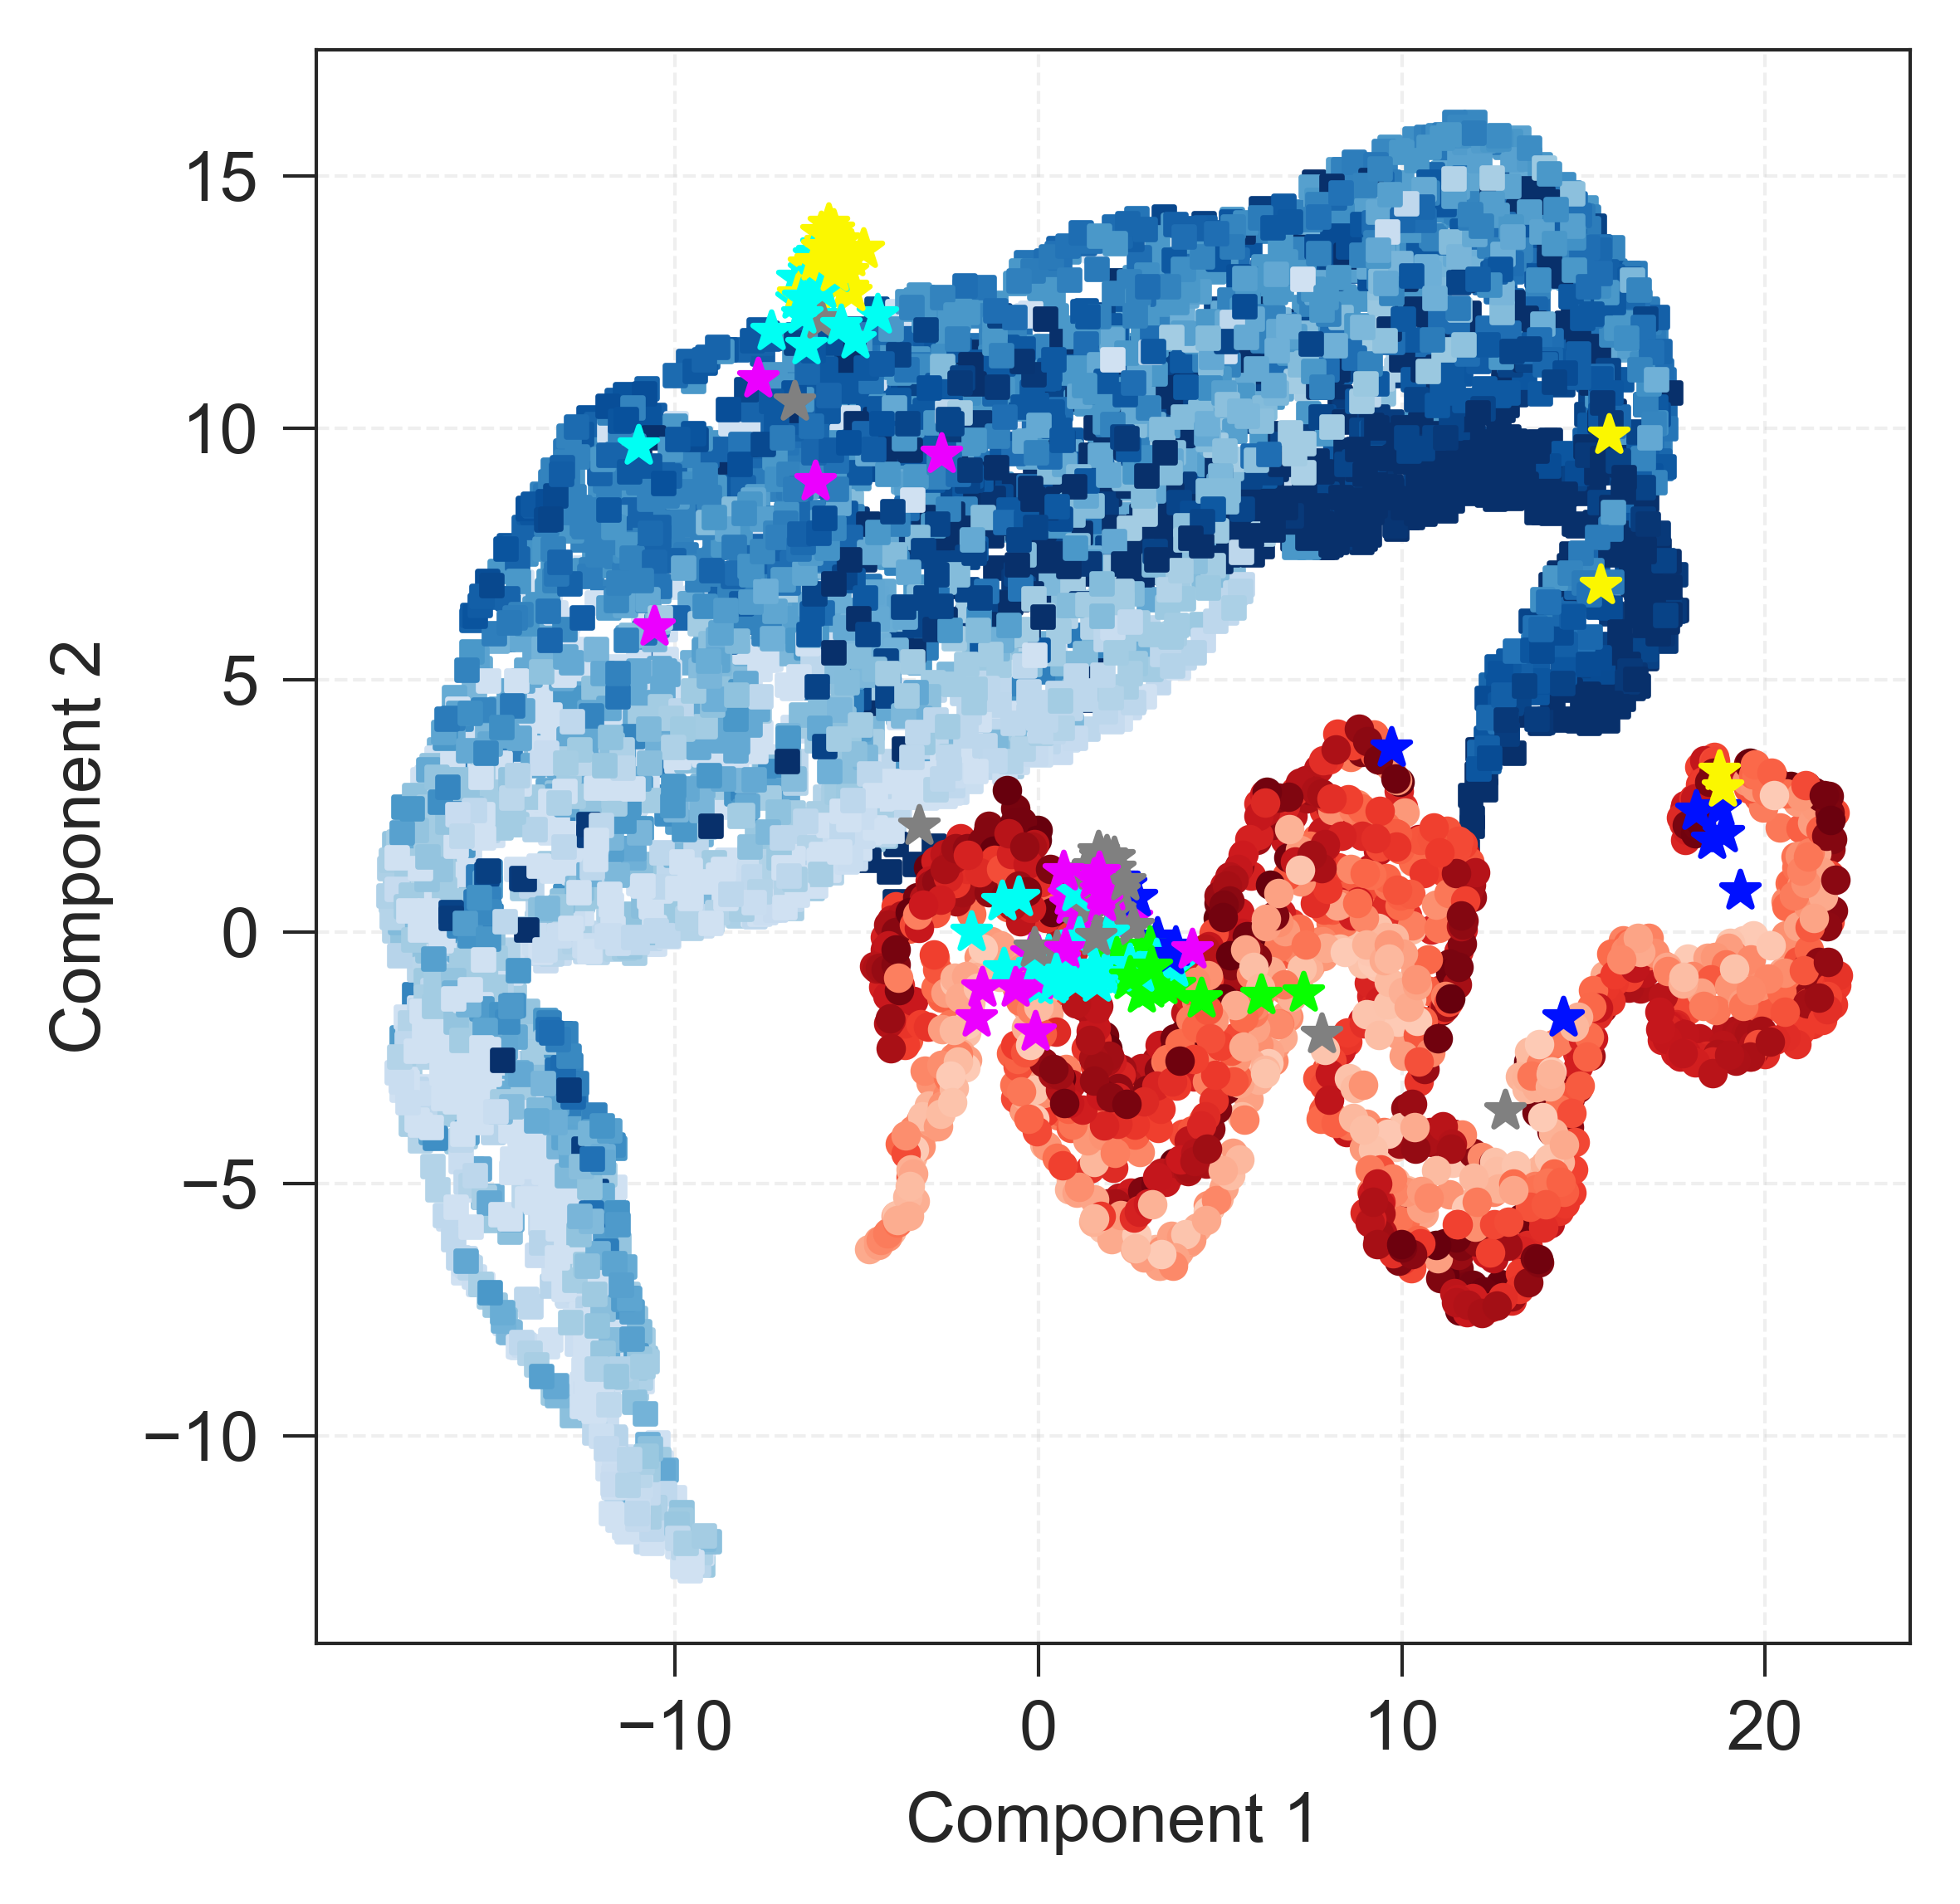

In [8]:
plt.rcParams['font.family'] = 'Arial'  #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 600,
    'figure.dpi': 600,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})

for subj in ['subj07', 'subj05', 'subj02', 'subj01']:
    # # for tgt in ['subj01', 'subj02', 'subj05', 'subj07']:
    tgt = subj

    sub_fmri_df = fmri_df[(fmri_df['metric'] == 'cka_36') & (fmri_df['tgt_model'] == tgt) & (fmri_df['src_model'] == subj)]
    sub_fmri_df = sub_fmri_df.sort_values(
        by=['src_model', 'tgt_model', 'metric', 'src_feature', 'tgt_feature']).reset_index(drop=True)

    max_layers = language_df.groupby('src_model')['src_feature'].max().reset_index()
    max_layers = max_layers.rename(columns={'src_feature': 'max_feature'})
    sub_language_df = language_df[(language_df['metric'] == 'cka_36') & (language_df['tgt_model'] == subj)]
    sub_language_df = sub_language_df.groupby(
        [
            'src_feature',
            'tgt_feature',
            'src_model',
            'tgt_model'
        ],
        as_index=False
    )[['score']].mean()
    sub_language_df = sub_language_df[sub_language_df['src_feature'] != 0]
    sub_language_df = sub_language_df.merge(max_layers, on='src_model', how='left')
    sub_language_df['src_feature'] = sub_language_df['src_feature'] / (sub_language_df['max_feature'])

    max_layers = vision_df.groupby('src_model')['src_feature'].max().reset_index()
    max_layers = max_layers.rename(columns={'src_feature': 'max_feature'})
    sub_vision_df = vision_df[(vision_df['metric'] == 'cka_36') & (vision_df['tgt_model'] == subj)]
    sub_vision_df = sub_vision_df.groupby(
        [
            'src_feature',
            'tgt_feature',
            'src_model',
            'tgt_model'
        ],
        as_index=False
    )[['score']].mean()
    sub_vision_df = sub_vision_df[sub_vision_df['src_feature'] != 0]
    sub_vision_df = sub_vision_df.merge(max_layers, on='src_model', how='left')
    sub_vision_df['src_feature'] = sub_vision_df['src_feature'] / (sub_vision_df['max_feature'])

    sub_language_df['modality'] = 'language'
    pivoted_language_df = sub_language_df.pivot_table(
        index=['src_model', 'src_feature', 'modality', 'tgt_model'],
        columns='tgt_feature',
        values='score'
    )

    sub_vision_df['modality'] = 'vision'
    pivoted_vision_df = sub_vision_df.pivot_table(
        index=['src_model', 'src_feature', 'modality', 'tgt_model'],
        columns='tgt_feature',
        values='score'
    )

    sub_fmri_df['modality'] = 'fmri'
    pivoted_fmri_df = sub_fmri_df.pivot_table(
        index=['src_model', 'src_feature', 'modality', 'tgt_model'],
        columns='tgt_feature',
        values='score'
    )
    pivoted_sum_df = pd.concat([pivoted_fmri_df, pivoted_language_df, pivoted_vision_df])

    # w_legend = 'w_legend' if legend else 'wo_legend'
    os.makedirs(f'{FIGURES_DIR}/scatter/{subj}-{tgt}', exist_ok=True)
    pca_features, plt_obj = main(
        df=pivoted_sum_df,
        method='umap',
        n_components=2,
        compute_new=True,
        save_path=f'{FIGURES_DIR}/scatter/{subj}-{tgt}/{subj}.png',
        hcp2yeo7=hcp2yeo7,
        # sample_size=2000,
        annotate=False,
        legend=True if '7' in subj else False,
        seed=int(subj[-1]) + 42,
    )
    plt.show()


    # pca_features, plt_obj = main(
    #     df=pivoted_sum_df,
    #     method='umap',
    #     n_components=3,
    #     compute_new=True,
    #     save_path=f'{FIGURES_DIR}/scatter/{subj}-{tgt}/{w_legend}/{subj}_3d.png',
    #     hcp2yeo7=hcp2yeo7,
    #     # sample_size=2000,
    #     annotate=False,
    #     legend=legend,
    #     seed=int(subj[-1]),
    # )

    plt.show()